# First Steps

Before we can jump into doing AB testing, we want to make sure we've got a decent grasp on the structure and features of the data we're working with. To do this, we're going to go ahead and open up our Northwind Database using SQLite, and load the data we're interested in into a dataframe.

In [1]:
import warnings
warnings.filterwarnings("ignore")

#Bring in SQLite to read the database
import sqlite3

#Bring in Pandas to organize the data into a frame
import pandas as pd

In [2]:
#Connect to the database
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

![Database Schema](Northwind_ERD_updated.png)

# Querying and Exploring Our Data

For right now, we've got a few questions that we want to explore. These questions are:

>**1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?**
>
>**2. Does offering a discount impact the total value of a sale? aka, is it successfully encouraging customers to purchase more?**
>
>**3. Are there some employees performing better than others? If so, we can use this insight to coach other employees.**
>
>**4. Is there a manager whose team is outperforming the other? This might influence pay raise of a manager, and help us coach develop the other team.**

Each question will require that we access different pieces of the database, but for right now if we were to look at questions 1 and 2, we can tell that we're going to be using our `OrderDetail` table which includes our order quantities, discounts applied, and unit price.

In [3]:
#For the first question we're really only interested in the OrderDetail table
#The OrderDetail table has information about Quantity ordered and the Discount applied
query = cur.execute("""SELECT * FROM OrderDetail""").fetchall()

#We're going to load this information into a dataframe for viewing
df = pd.DataFrame(query)
df.columns = [x[0] for x in cur.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [4]:
#Let's find out about this table
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [6]:
df.shape

(2155, 6)

In [7]:
df.isnull().sum()

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

In [8]:
df.nunique()

Id           2155
OrderId       830
ProductId      77
UnitPrice     116
Quantity       55
Discount       11
dtype: int64

### What have we found out?

Really we've just gotten a brief understanding of what's in this table. We know that altogether we're only looking at 830 orders total of 77 unique products. The "Discount" that's applied seems to only apply at 11 levels total, ranging from 0% to 25%.

Let's find out about our discounts offerings.

In [9]:
df.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

So, we've got some odd discounts in here, but definitely covering  0-25%. I want to find out more information about the way these discounts are applied to the total group overall.

Discount
0.00    1317
0.01       1
0.02       2
0.03       3
0.04       1
0.05     185
0.06       1
0.10     173
0.15     157
0.20     161
0.25     154
Name: Discount, dtype: int64


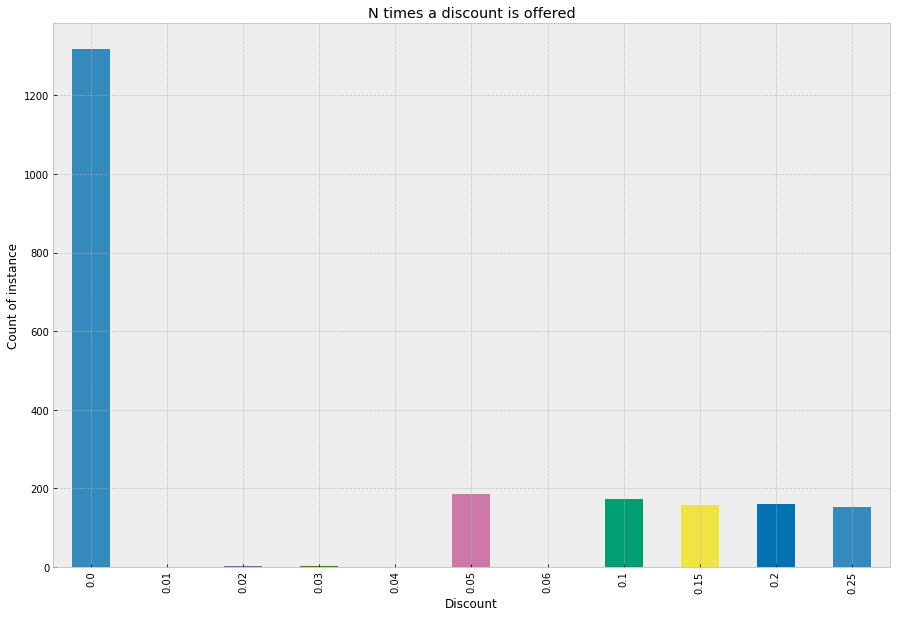

In [34]:
#Count how many times a given discount is used,
#then plots this on a bar graph so that we have a visual representation
import matplotlib.pyplot as plt

plt.style.use('bmh')

print(df.groupby('Discount')['Discount'].count())

plt.figure(figsize=(15,10))
df.groupby('Discount')['Discount'].count().plot.bar()
plt.ylabel('Count of instance')
plt.title('N times a discount is offered');

Discount
0.00    21.715262
0.01     2.000000
0.02     2.000000
0.03     1.666667
0.04     1.000000
0.05    28.010811
0.06     2.000000
0.10    25.236994
0.15    28.382166
0.20    27.024845
0.25    28.240260
Name: Quantity, dtype: float64


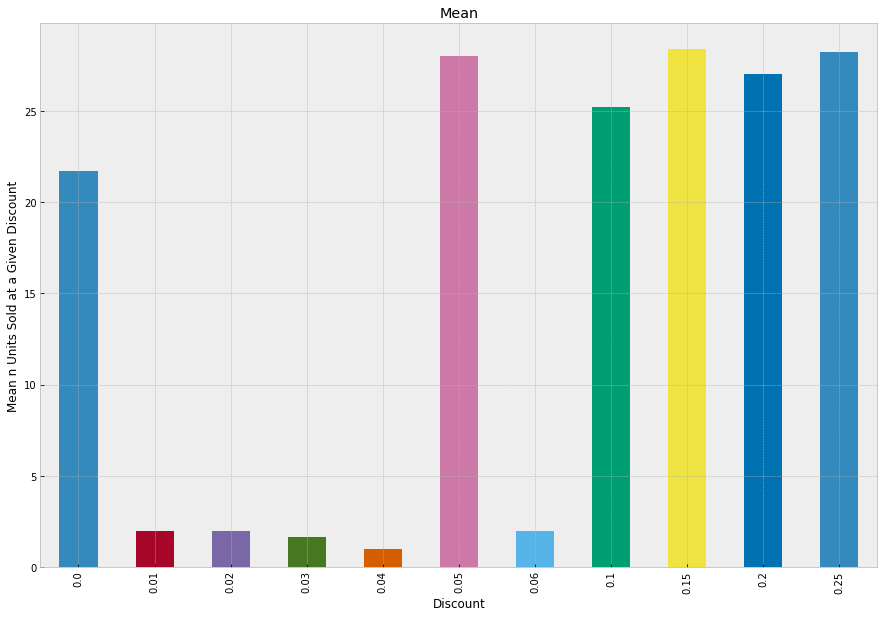

In [11]:
#Find the mean of 'Quantity' associated with each discount,
#Then plot this on a bar graph so we have a visual representation.
print(df.groupby('Discount')['Quantity'].mean()),

plt.figure(figsize=(15,10))
df.groupby('Discount')['Quantity'].mean().plot.bar()
plt.ylabel('Mean n Units Sold at a Given Discount')
plt.title('Mean');

### Some Conclusions We Can Already Draw

We know that it looks like not all discounts are created equal! For example, discounts of 1%, 2%, 3%, 4% and 6%, are only used 1, 2, or 3 times total. In these cases, **we can't really definitively say they do or do not have an impact, because the sample size is too small.**

So, that's something that we can note:

>*There's not enough data to conclude whether discounts of 1%, 2%, 3%, 4%, or 6% have an impact on the quantity of units ordered.*

As a result, we can also note that:

>*There's not enough data to conclude whether discounts of 1%, 2%, 3%, 4%, or 6% impact the total value of a sale.*

That being said, we are going to try and work without information on those discounts. Let's pull out the data that we can actually work with and star setting up our tests.

In [12]:
#Let's trim a dataframe to answer this question about discountsm, note that | is an 'or' symbol
df2 = df.loc[(df['Discount'] == 0.00) |
             (df['Discount'] == 0.05) |
             (df['Discount'] == 0.1) |
             (df['Discount'] == 0.15) |
             (df['Discount'] == 0.2) |
             (df['Discount'] == 0.25)]

#List of discounts, to make this easy
discounts = ['0', '0.05', '0.1', '0.15', '0.2', '0.25']

#Need to create arrays for the populations w/ discounts
d0 = df2.loc[df2['Discount'] == 0].Quantity.values
d05 = df2.loc[df2['Discount'] == 0.05].Quantity.values
d1 = df2.loc[df2['Discount'] == 0.1].Quantity.values
d15 = df2.loc[df2['Discount'] == 0.15].Quantity.values
d2 = df2.loc[df2['Discount'] == 0.2].Quantity.values
d25 = df2.loc[df2['Discount'] == 0.25].Quantity.values

#Make a list of our sample arrays
pops = [d0, d05, d1, d15, d2, d25]

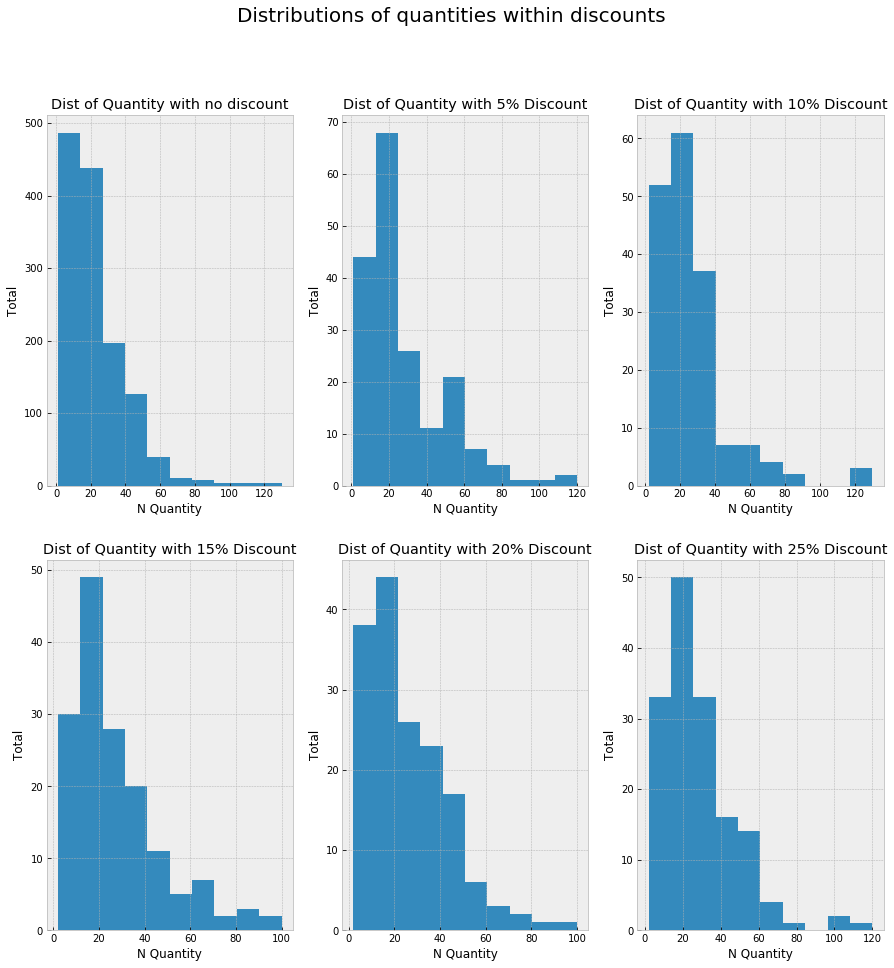

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,15))
fig.suptitle("Distributions of quantities within discounts", fontsize = 20);

ax1 = fig.add_subplot(2,3,1)
ax1.hist(d0);
ax1.set_title('Dist of Quantity with no discount')
ax1.set_xlabel('N Quantity')
ax1.set_ylabel('Total')

ax2 = fig.add_subplot(2,3,2)
ax2.hist(d05);
ax2.set_title('Dist of Quantity with 5% Discount')
ax2.set_xlabel('N Quantity')
ax2.set_ylabel('Total')

ax3 = fig.add_subplot(2,3,3)
ax3.hist(d1);
ax3.set_title('Dist of Quantity with 10% Discount')
ax3.set_xlabel('N Quantity')
ax3.set_ylabel('Total')

ax4 = fig.add_subplot(2,3,4)
ax4.hist(d15);
ax4.set_title('Dist of Quantity with 15% Discount')
ax4.set_xlabel('N Quantity')
ax4.set_ylabel('Total')

ax5 = fig.add_subplot(2,3,5)
ax5.hist(d2);
ax5.set_title('Dist of Quantity with 20% Discount')
ax5.set_xlabel('N Quantity')
ax5.set_ylabel('Total')


ax6 = fig.add_subplot(2,3,6)
ax6.hist(d25);
ax6.set_title('Dist of Quantity with 25% Discount')
ax6.set_xlabel('N Quantity')
ax6.set_ylabel('Total');

Clearly, nothing is normally distributed. We can see some really heavy tails here, but we can better visualize how heavy these tails are and where these outliers are by using boxplots.

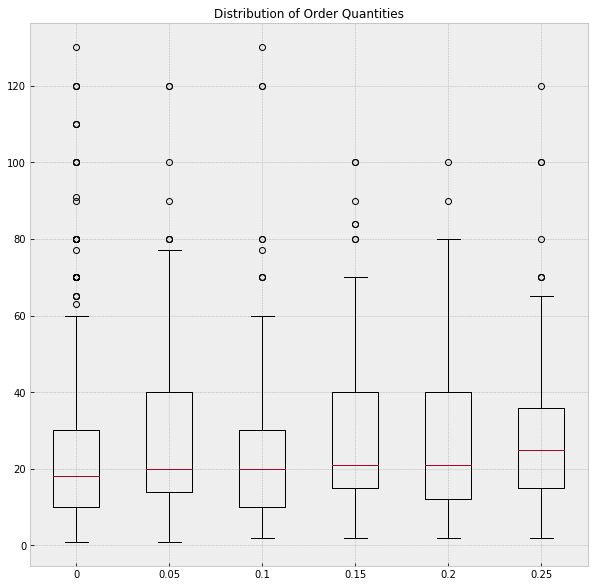

In [14]:
plt.figure(figsize = (10, 10))
plt.boxplot(pops, labels = discounts)
plt.title('Distribution of Order Quantities', fontsize = 12);

Right now, it looks like we've got a lot of outliers thare helping to skew our data. We can see this in our histograms and in our box plots - in the box plot, each outlier is given a dot indicator. Because we're generally going to be comparing means, and means are sensitive to outliers, it's due diligence to remove them. We're going to write a quick function that is going to take in an array and then remove those entries which are significant outliers. We'll define an outlier as >3 standard deviations from the mean.

In [15]:
import numpy as np

#Define function
def remove_outliers(data):
    data = data[data < (data.mean() + (3*data.std()))]
    data = data[data > (data.mean() - (3*data.std()))]
    return data

In [16]:
#Function test
len(remove_outliers(d0)) < len(d0)

True

It looks like our function is working, so let's go ahead and try plotting these again to see how it has impacted the spread of the data.

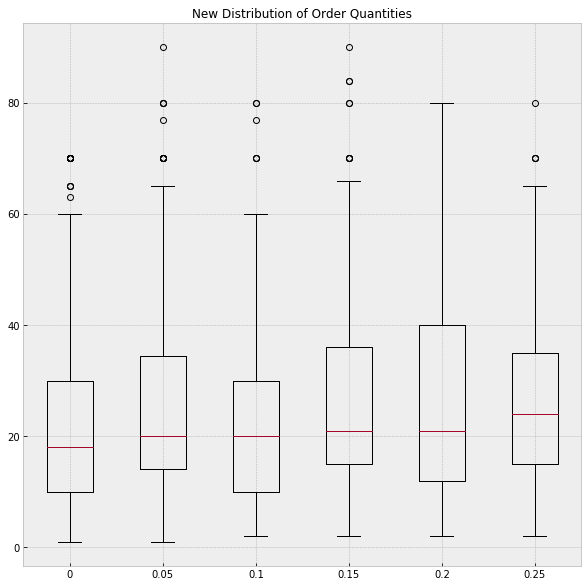

In [17]:
#Run the function to truncate our arrays
d0 = remove_outliers(d0)
d05 = remove_outliers(d05)
d1 = remove_outliers(d1)
d15 = remove_outliers(d15)
d2 = remove_outliers(d2)
d25 = remove_outliers(d25)

#Repopulate the list so that we're not working with the old values anymore
pops = [d0, d05, d1, d15, d2, d25]

plt.figure(figsize = (10, 10))
plt.boxplot(pops, labels = discounts)
plt.title('New Distribution of Order Quantities', fontsize = 12);

Our distributions look much neater, so it looks like this worked out. You can see that after we ran the formula, we're still left with a couple big outliers - but not nearly as many as before. Let's take a look at how our new data is distributed.

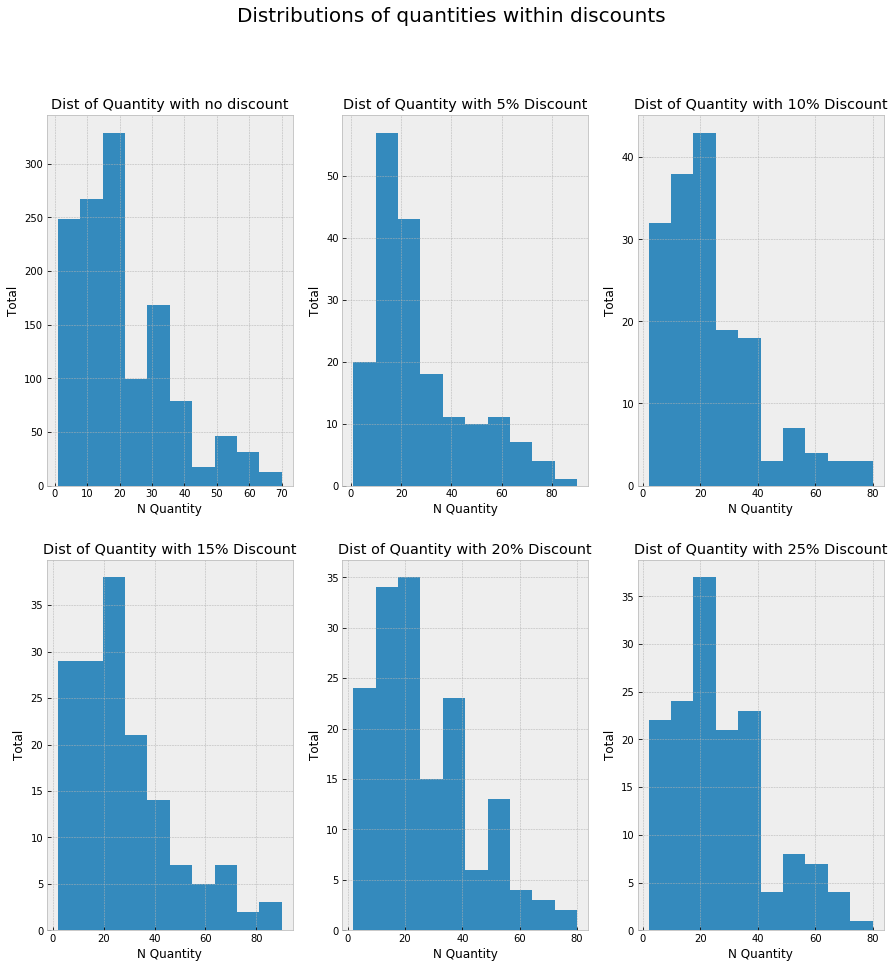

In [18]:
fig = plt.figure(figsize = (15,15))
fig.suptitle("Distributions of quantities within discounts", fontsize = 20);

ax1 = fig.add_subplot(2,3,1)
ax1.hist(d0);
ax1.set_title('Dist of Quantity with no discount')
ax1.set_xlabel('N Quantity')
ax1.set_ylabel('Total')

ax2 = fig.add_subplot(2,3,2)
ax2.hist(d05);
ax2.set_title('Dist of Quantity with 5% Discount')
ax2.set_xlabel('N Quantity')
ax2.set_ylabel('Total')

ax3 = fig.add_subplot(2,3,3)
ax3.hist(d1);
ax3.set_title('Dist of Quantity with 10% Discount')
ax3.set_xlabel('N Quantity')
ax3.set_ylabel('Total')

ax4 = fig.add_subplot(2,3,4)
ax4.hist(d15);
ax4.set_title('Dist of Quantity with 15% Discount')
ax4.set_xlabel('N Quantity')
ax4.set_ylabel('Total')

ax5 = fig.add_subplot(2,3,5)
ax5.hist(d2);
ax5.set_title('Dist of Quantity with 20% Discount')
ax5.set_xlabel('N Quantity')
ax5.set_ylabel('Total')


ax6 = fig.add_subplot(2,3,6)
ax6.hist(d25);
ax6.set_title('Dist of Quantity with 25% Discount')
ax6.set_xlabel('N Quantity')
ax6.set_ylabel('Total');

# Answering The First Question:  Do discounts drive quantity?

Before we can actually start running a test, remember, we have to define our null hypothesis (H0), and our alternative hypothesis (Ha). In this case, it should look something like this:

> H0: Discounts do not impact the quantity of items ordered in a purchase

> HA: Discounts increase the quantity of items ordered in a purchase

We also have to define our alpha and p-value which will help us determine whether the difference we observe is statistically significant:

> P = 0.05, Alpha = 0.95

So, when we're running tests, we're looking to make sure 1) whether that difference does exist, and 2) whether that difference is strong enough that there's a less than 5% chance it occurred at random.

Our data is normal-ish, so we can use a T-test. If we're going to run a t-test, we need to make sure we run the right t-test. If the variance of samples are very different, we need to use a Welch's t-test; otherwise we can use a standard t-test.

In [19]:
for x in pops:
    print(f"Var is {x.var()}")

Var is 215.9414995401879
Var is 374.26107957976086
Var is 280.94408304498273
Var is 373.5643704474506
Var is 297.7384597128278
Var is 283.80623656857153


Since it looks like there's a lot of variation among the variance of each set, we'll run a Welch's t-test on each discount sample against the population w/out a discount.

In [20]:
import scipy.stats as stats

ls = ['d0', 'd05', 'd1', 'd15', 'd2', 'd25']
count = 0

#Welch's T-Test
while count < 6:
    for x in pops:
        result = stats.ttest_ind(d0, x, equal_var = False)
        if result[1] < 0.05:
            print(f"Welch's T-Test shows that d0 differs significantly from {ls[count]}  w/ p-value {result[1]}")
        count += 1

Welch's T-Test shows that d0 differs significantly from d05  w/ p-value 7.003108456076047e-05
Welch's T-Test shows that d0 differs significantly from d1  w/ p-value 0.02945945392598143
Welch's T-Test shows that d0 differs significantly from d15  w/ p-value 2.8678142464556142e-05
Welch's T-Test shows that d0 differs significantly from d2  w/ p-value 0.00011916580526090582
Welch's T-Test shows that d0 differs significantly from d25  w/ p-value 3.047148484160931e-05


To deal with the fact that the data isn't perfectly normal, we can also use ANOVA and see how that pans out.

In [21]:
#This is an ANOVA test
count = 0
while count < 6:
    for x in pops:
        result = stats.f_oneway(d0, x)
        if result[1] < 0.05:
            print(f"ANOVA shows that d0 differs significantly from {ls[count]}  w/ p-value {result[1]}")
        count += 1

ANOVA shows that d0 differs significantly from d05  w/ p-value 6.771213493084748e-07
ANOVA shows that d0 differs significantly from d1  w/ p-value 0.015207250866526556
ANOVA shows that d0 differs significantly from d15  w/ p-value 1.1286039804872102e-07
ANOVA shows that d0 differs significantly from d2  w/ p-value 8.64366294883859e-06
ANOVA shows that d0 differs significantly from d25  w/ p-value 1.9357230647251493e-06


Looks like every discount produces statistically significant impacts, but that isn't necessarily useful information. We want to measure the size of the effect our discounts have to make a more informed business decision about whether these discounts are useful.

To do this, we can use Cohen's d. This isn't built into Scipy, so we're going to have to make a function for it:

In [22]:
from numpy import sqrt

def cohens_d(a, b):
    mu0 = a.std()
    mu1 = b.std()
    n0 = len(a)
    n1 = len(b)
    s = sqrt(((n0 - 1) * a.var() + (n1 - 1) * b.var()) / (n0 + n1 - 2))
    d = (mu0 - mu1) / s
    return d


#Because the denominator is [x - y], we're running these loops as [Discount - none] so that the result comes back positive.
#Because we know discount is having a positive effect, it's more intuitive to want to see a positive Cohen's d,
#and setting it up this way helps us see it more easily.
for x in pops:
    print(cohens_d(x, d0))

0.0
0.3031688909345824
0.13824261807062765
0.30371633625071365
0.17074126611843884
0.14408790582078712


We've got our results, let's try and get some useful information into a dataframe for easier review.

In [23]:
ls = ['d0', 'd05', 'd1', 'd15', 'd2', 'd25']
count = 0
summary = pd.DataFrame(columns = ['Sample', 'Mean', 'std dv', 'var', 'Welchs T-Test Result', 'ANOVA Result', "Effect Size (Cohen's)"])

while count < 6:
    for x in pops:
        T_result = stats.ttest_ind(d0, x, equal_var = False)
        ANOVA_result = stats.f_oneway(d0, x)
        cohens = cohens_d(x, d0)
        summary.loc[count] = [ls[count], x.mean(), x.std(), x.var(), T_result[1], ANOVA_result[1], cohens]
        count += 1

summary

,Sample,Mean,std dv,var,Welchs T-Test Result,ANOVA Result,Effect Size (Cohen's)
0,d0,20.540478,14.694948,215.941500,1.000000,1.000000e+00,0.000000
1,d05,26.604396,19.345828,374.261080,0.000070,6.771213e-07,0.303169
2,d1,23.505882,16.761387,280.944083,0.029459,1.520725e-02,0.138243
3,d15,27.458065,19.327813,373.564370,0.000029,1.128604e-07,0.303716
4,d2,26.169811,17.255100,297.738460,0.000119,8.643663e-06,0.170741
5,d25,26.682119,16.846550,283.806237,0.000030,1.935723e-06,0.144088


So, we can see that our most significant results are at discounts of 15%, 25% and 5%. However, the discounts with the largest effect, as measured by Cohen's, are only 5% and 15%. As such, we can conclude that **discounts of 5% and 15% are both significant and impactful.**

To visualize these, let's take a look at how our discount samples compare to the population without discounts.

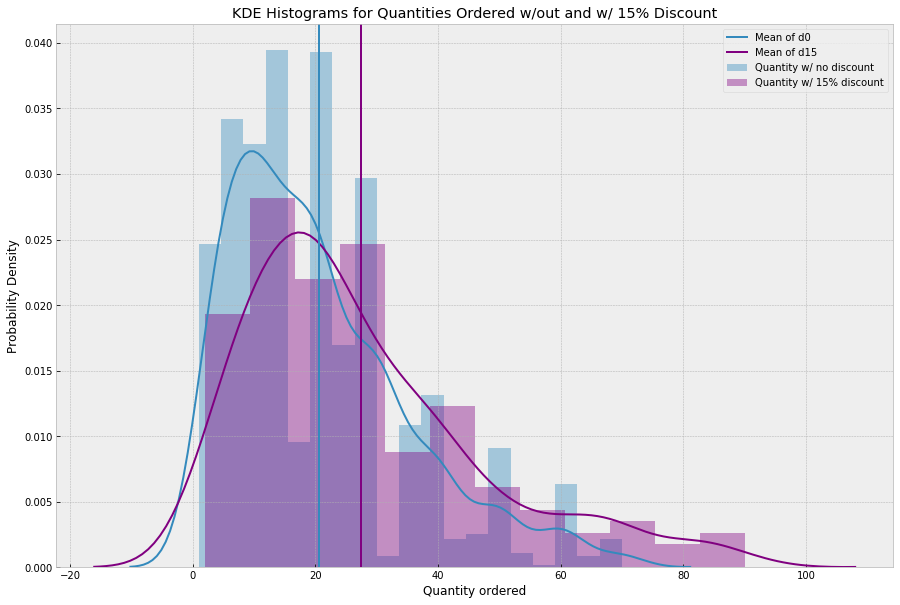

In [24]:
import seaborn as sns
plt.figure(figsize = (15,10))

plt.title('KDE Histograms for Quantities Ordered w/out and w/ 15% Discount')

sns.distplot(d0)
sns.distplot(d15, color = 'purple')

plt.axvline(x = d0.mean())
plt.axvline(x = d15.mean(), color = 'purple')

plt.legend(['Mean of d0', 'Mean of d15', 'Quantity w/ no discount', 'Quantity w/ 15% discount'])
plt.xlabel('Quantity ordered')
plt.ylabel('Probability Density');

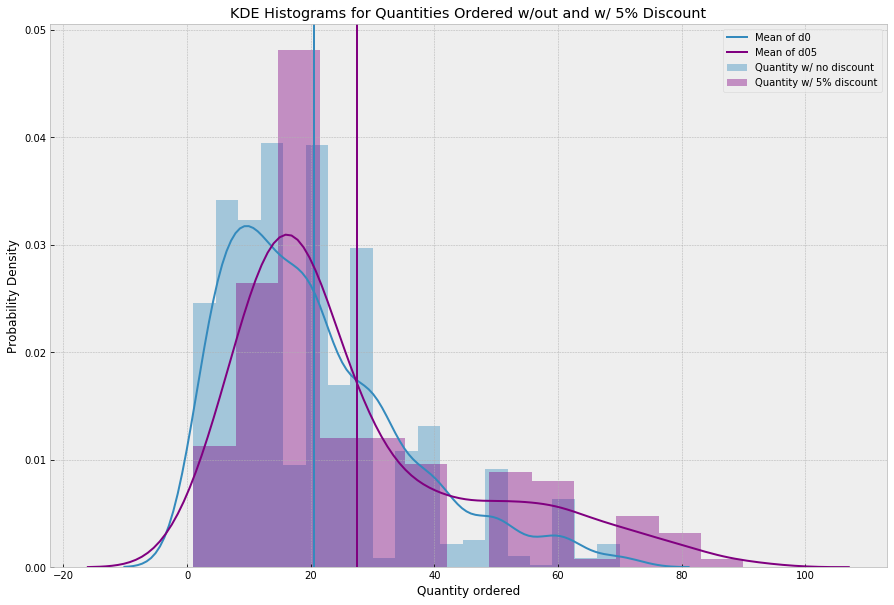

In [25]:
plt.figure(figsize = (15,10))

plt.title('KDE Histograms for Quantities Ordered w/out and w/ 5% Discount')

sns.distplot(d0)
plt.axvline(x = d0.mean())

sns.distplot(d05,  color = 'purple')
plt.axvline(x = d15.mean(), color = 'purple')

plt.legend(['Mean of d0', 'Mean of d05', 'Quantity w/ no discount', 'Quantity w/ 5% discount'])
plt.xlabel('Quantity ordered')
plt.ylabel('Probability Density');

### What Conclusions Can We Draw?

It looks like all discounts drive a significant difference in how quantities are odered, but across the board the effect seems small. In the cases of discounts of 5% and 15%, however, we're looking at much more significant differences with much more significant impacts.

Ideally, we'd want to standardize the discounts that we offer based on this information, and strike any discount greater than 15%, as this just eats into the bottom line without driving quantity.

# Answering the Second Question:  Do discounts drive sales?

Since we're looking at sales value for our order, we can just take a look back at our original frame that we made to begin answering the first question. However, you'll note that there's no column which calculates the total sale value of the order, so we'll have to add that manually.

In [26]:
df2.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [27]:
#Add in a column for sales value and display the new dataframe
df2['Sale'] = (df2.UnitPrice * df2.Quantity) * (1 - df2.Discount)
df2.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Sale
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


Just like before, we'll split our data into two sets:  orders w/ a discount, and orders w/out a discount. Since we'll want an easy way to calculate the total sale value of an order, we can do this using a `groupby` statement which will first organize our data by `OrderId`, then calculate the total value of our `Sale` column, which was calculated on an individual item basis.

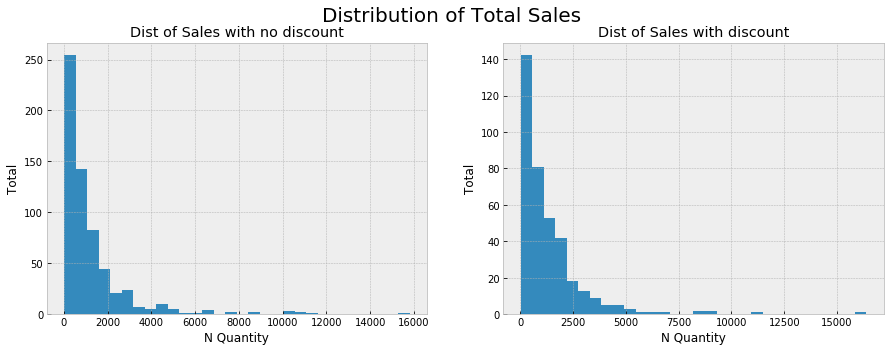

In [28]:
#Creates our new datasets
df3 = df2.loc[df2['Discount'] == 0]
df4 = df2.loc[df2['Discount'] > 0]

#Gives us our arrays for comparison
discount = df4.groupby('OrderId')['Sale'].sum().values
no_discount = df3.groupby('OrderId')['Sale'].sum().values

#Plots the groups to visualize how they look overall
fig = plt.figure(figsize = (15,5))
fig.suptitle("Distribution of Total Sales", fontsize = 20);

ax1 = fig.add_subplot(1,2,1)
ax1.hist(no_discount, bins = 30);
ax1.set_title('Dist of Sales with no discount')
ax1.set_xlabel('N Quantity')
ax1.set_ylabel('Total')

ax2 = fig.add_subplot(1,2,2)
ax2.hist(discount, bins = 30);
ax2.set_title('Dist of Sales with discount')
ax2.set_xlabel('N Quantity')
ax2.set_ylabel('Total');

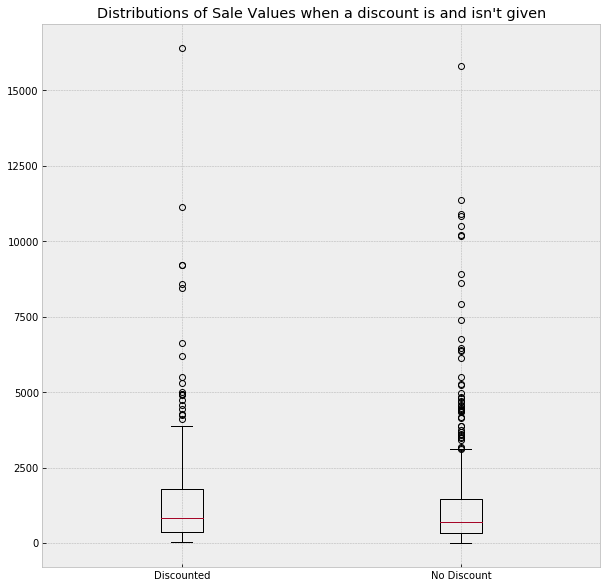

In [29]:
plt.figure(figsize = (10,10))
plt.title("Distributions of Sale Values when a discount is and isn't given")
plt.boxplot(x =[discount, no_discount], labels = ['Discounted', 'No Discount']);

Just as before, our data has some very long tails and a lot of visible outliers. We're going to apply our `remove_outliers` function that we created earlier to help out in making our sets more normal for comparison, then plot what they look like once they've had their outliers removed.

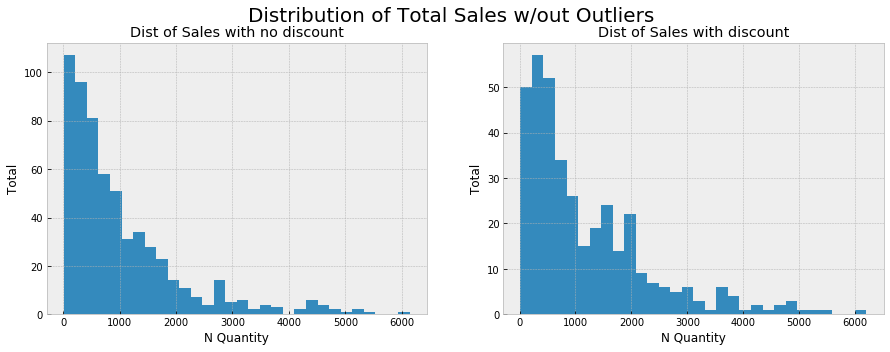

In [30]:
discount = remove_outliers(discount)
no_discount = remove_outliers(no_discount)

fig = plt.figure(figsize = (15,5))
fig.suptitle("Distribution of Total Sales w/out Outliers", fontsize = 20);

ax1 = fig.add_subplot(1,2,1)
ax1.hist(no_discount, bins = 30);
ax1.set_title('Dist of Sales with no discount')
ax1.set_xlabel('N Quantity')
ax1.set_ylabel('Total')

ax2 = fig.add_subplot(1,2,2)
ax2.hist(discount, bins = 30);
ax2.set_title('Dist of Sales with discount')
ax2.set_xlabel('N Quantity')
ax2.set_ylabel('Total');

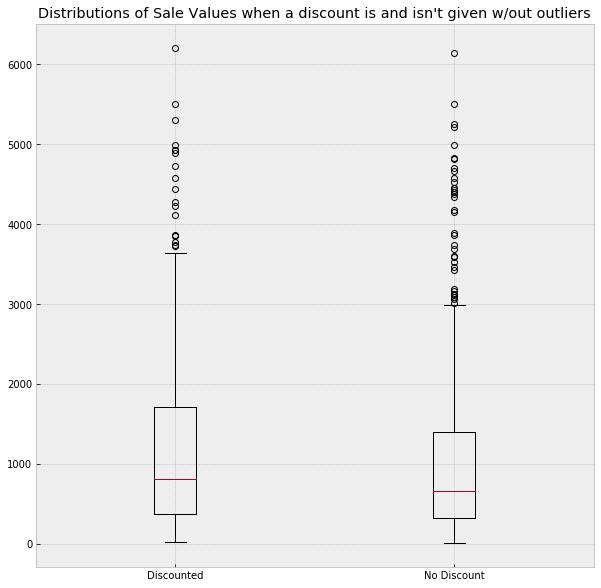

In [31]:
plt.figure(figsize = (10,10))
plt.title("Distributions of Sale Values when a discount is and isn't given w/out outliers")
plt.boxplot(x =[discount, no_discount], labels = ['Discounted', 'No Discount']);

We're still sitting on some tails, but as we can see, it looks better. Before we test, let's go ahead and plot our KDE diagram as we did before to see if we can visualize/predict the outcome of the test.

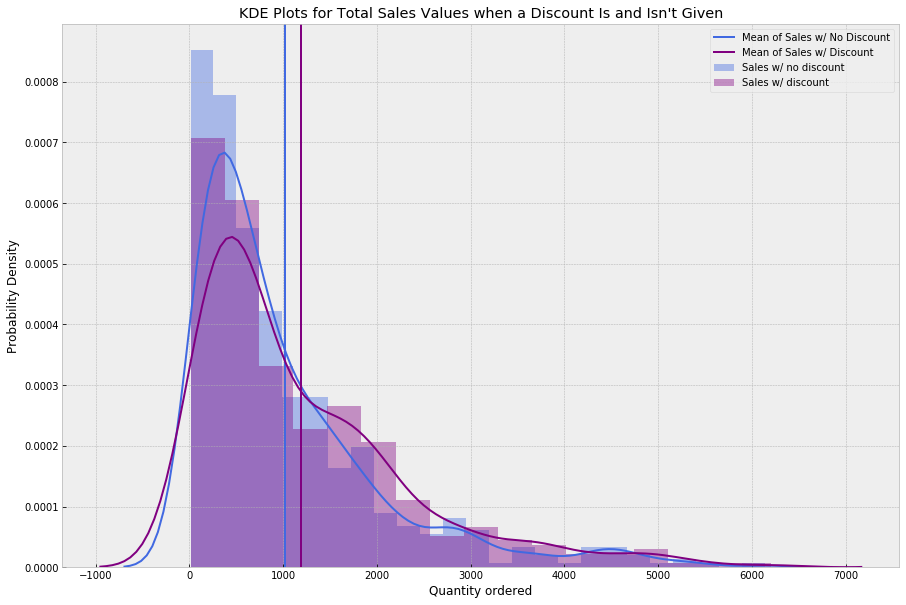

In [32]:
plt.figure(figsize = (15,10))

plt.title("KDE Plots for Total Sales Values when a Discount Is and Isn't Given")

sns.distplot(no_discount, color = 'royalblue')
plt.axvline(x = no_discount.mean(), color = 'royalblue')

sns.distplot(discount, color = 'purple')
plt.axvline(x = discount.mean(), color = 'purple')

plt.legend(['Mean of Sales w/ No Discount', 'Mean of Sales w/ Discount', 'Sales w/ no discount', 'Sales w/ discount'])
plt.xlabel('Quantity ordered')
plt.ylabel('Probability Density');

Looks like there's a pretty significant difference, however, before we can run the test, we'll have to define our null and alternative hypotheses, as well as our P and Alpha values.

> H0: Discounts do not impact the total sale value of a purchase

> HA: Discounts increase the total sale value of a purchase

> P = 0.05, Alpha = 0.95

So, just as before, let's run a quick Welch's T-test and an ANOVA, and then take a look at how significant the difference is by using Cohen's d.

In [33]:
t_result = stats.ttest_ind(discount, no_discount, equal_var = False)
ANOVA_result = stats.f_oneway(discount, no_discount)
cohens = cohens_d(discount, no_discount)

print(f"Sales w/ discounts vary with p-value of {t_result[1]} for Welch's t-test and {ANOVA_result[1]} w/ ANOVA. The effect size as described by Cohen's d is {round(cohens, 3)}.")

Sales w/ discounts vary with p-value of 0.01939825420048097 for Welch's t-test and 0.017194783580176298 w/ ANOVA. The effect size as described by Cohen's d is 0.08.


### What Conclusions Can We Draw?

While there's a significant difference between our population w/ discounts and our population w/out a discount, the overall impact of discounts on total sales seems negligible - that is to say, it doesn't seem to improve total sales by a lot.

One of the issues we highlighted earlier is that the level of discounts vary widely, but if you revisit the distributions of our discount populations, you can see that we're getting discounts applied to all levels and types of sales, regardless of total dollar on the order or quantity ordered. It's likely that this lack of standardization is impacting the minimal difference.

We'd recommend standardizing practices for discounts, not just in terms of what levels at which they are offered, but also for quantities and dollars purchased.